In [125]:
import pandas as pd
from fastai.collab import *
from sklearn.neighbors import NearestNeighbors
import json


In [124]:
# Import List of Games
gamelist_filename = '2019-05-02.csv'
reviewlist_filename = 'bgg-13m-reviews.csv'
recommendation_export_filename = 'recommendations.json'

In [113]:
games = pd.read_csv(gamelist_filename)
# games.describe()
games.sort_values('Users rated',ascending=False,inplace=True)
games.rename(index=str, columns={"Bayes average": "Geekscore",'Name':'name'}, inplace=True)

In [8]:
# Import Reviews
reviews = pd.read_csv('bgg-13m-reviews.csv', index_col = 0);

C:\Users\Jerry\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
reviews.head();

In [12]:
# Create a Data Bunch, a data object used by the learner
data = CollabDataBunch.from_df(reviews, user_name='user', item_name='name', rating_name='rating', seed=42)
# data.show_batch()

## EmbeddingDotBias Model

In [130]:

def createDotBiasLearner(data, n_weights = 50, y_range=None):
    learner = collab_learner(data, n_factors=n_weights, y_range=y_range)
    print(learner.summary())
    return learner

def plotLearningRateVsLoss(learner):
    lr_find(learner)
    learner.recorder.plot()

learner = createDotBiasLearner(data, n_weights=50, y_range=(2.,10))

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [50]                 13,926,300 True      
______________________________________________________________________
Embedding            [50]                 836,800    True      
______________________________________________________________________
Embedding            [1]                  278,526    True      
______________________________________________________________________
Embedding            [1]                  16,736     True      
______________________________________________________________________

Total params: 15,058,362
Total trainable params: 15,058,362
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



In [19]:
# Find a good learning rate
lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


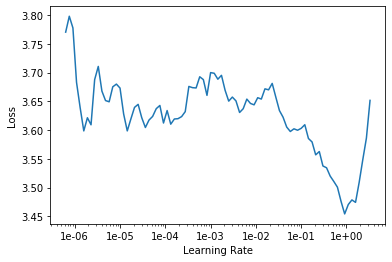

In [12]:
# learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(5, 1e-2, wd=0.10)


epoch,train_loss,valid_loss,time
0,2.231084,2.189549,23:25


In [46]:
# learner.save("trained_model", return_path=True)
learner.load("trained_model");

In [16]:
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(278526, 50)
  (i_weight): Embedding(16736, 50)
  (u_bias): Embedding(278526, 1)
  (i_bias): Embedding(16736, 1)
)

In [22]:
# learner.recorder.plot_losses()

AttributeError: 'CollabLearner' object has no attribute 'recorder'

## Find Similar Games

In [65]:
# Want games with at least 50 reviews

In [41]:
# Group the reviews by game, get the rating column and aggregate each group by with its mean and count
games_by_all_users = reviews.groupby('name')['rating'].agg(['mean','count'])
games_by_all_users.sort_values('mean',ascending=False, inplace=True)

# Get Top Games
top_games = games_by_all_users[games_by_all_users['count']>100].sort_values('mean',ascending=False).index
game_indexes = games_by_all_users.index
mean_ratings = reviews.groupby('name')['rating'].mean().round(2)

In [35]:
print(len(top_games)) # There are 13107 games with at least 50 reviews

9196


In [49]:
top_game_bias = learner.bias(top_games, is_item=True)
all_game_bias = learner.bias(game_indexes, is_item=True)

In [30]:
shapemean_ratings = reviews.groupby('name')['rating'].mean()

In [36]:
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_games,game_bias)]

In [57]:
game_weights = learner.weight(game_indexes, is_item=True)
game_weights.shape
game_pca = game_weights.pca(3)
game_pca.shape
game_np_weights = game_pca.numpy()
game_np_weights
game_weights = game_weights.numpy()

In [62]:
nn = NearestNeighbors(n_neighbors=len(game_indexes))
fitnn = nn.fit(game_np_weights)

In [55]:
distance, neighbours = fitnn.kneighbors(X=[game_np_weights[1]], n_neighbors=5)

In [115]:
def getRecommendations( game, n_recommendations):
    distance, neighbours = fitnn.kneighbors(X=[game_np_weights[game]], n_neighbors=n_recommendations + 1)
    recommend_list=[]
    for i,value in enumerate(neighbours, start=0):
#         print(game_indexes[value], distance[i])
        recommend_list.append(game_indexes[value])
    return recommend_list[0].to_list()

In [118]:
recommend_list = getRecommendations(1, 10)
recommend_list

['Animator vs Animation',
 'Zero Hour: Survival Horror Card Game',
 'Qwarks',
 'Enigmàrius',
 'Jungli-La',
 'Hypnose',
 'Grand National',
 'The Old Contemptibles',
 "The Coin Tribes' Revolt: Boudica's Rebellion Against Rome",
 'Spiel mit Lukas: Dribbel-Fieber',
 'NUTS!']

In [128]:
def exportRecommendationList( output_file, game_index, num_recommendations ):
    game_recommendations_map = {}
    
    for i in range(len(game_index)):
        result = getRecommendations( i , num_recommendations )
        game_recommendations_map[result[0]] = result[1:]
        
    with open( output_file, 'w') as fp:
        json.dump(game_recommendations_map, fp)
        
    return game_recommendations_map

game_map = exportRecommendationList( recommendation_export_filename, game_indexes, 21 )

In [120]:
#output the recommand list
# games.set_index("name",inplace =True)
games.loc[recommend_list]

,ID,Year,Rank,Average,Geekscore,Users rated,URL,Thumbnail
name,,,,,,,,
Animator vs Animation,236332,2018,12984,9.59,5.510,34,/boardgame/236332/animator-vs-animation,https://cf.geekdo-images.com/micro/img/IOahMM3...
Zero Hour: Survival Horror Card Game,145764,2014,15463,4.73,5.479,36,/boardgame/145764/zero-hour-survival-horror-ca...,https://cf.geekdo-images.com/micro/img/nuaVB71...
Qwarks,222913,2017,10766,7.16,5.530,31,/boardgame/222913/qwarks,https://cf.geekdo-images.com/micro/img/YI1_7t-...
Enigmàrius,152824,2013,11373,6.55,5.524,33,/boardgame/152824/enigmarius,https://cf.geekdo-images.com/micro/img/FnHRA6s...
Jungli-La,215154,2016,14399,5.39,5.495,55,/boardgame/215154/jungli-la,https://cf.geekdo-images.com/micro/img/ImtmvKk...
Hypnose,199247,2017,14968,4.88,5.487,31,/boardgame/199247/hypnose,https://cf.geekdo-images.com/micro/img/W9lPaZc...
Grand National,12111,2001,9931,7.18,5.538,33,/boardgame/12111/grand-national,https://cf.geekdo-images.com/micro/img/1paJePZ...
The Old Contemptibles,17430,2005,9080,6.87,5.548,47,/boardgame/17430/old-contemptibles,https://cf.geekdo-images.com/micro/img/elnjMpj...
The Coin Tribes' Revolt: Boudica's Rebellion Against Rome,251213,2018,9694,7.26,5.541,30,/boardgame/251213/coin-tribes-revolt-boudicas-...,https://cf.geekdo-images.com/micro/img/p3s_dDh...


### Exploration

In [14]:
# Group the reviews by game, get the rating column and aggregate each group by with its mean and count
games_by_all_users = reviews.groupby('name')['rating'].agg(['mean','count'])
games_by_all_users.sort_values('mean',ascending=False, inplace=True)

# How many games with ratings/reviews
# Machine learning does recommendation on top X games.
games_by_all_users

,mean,count
name,,
Limbo: Eternal War,9.597143,35
Animator vs Animation,9.588235,34
TerroriXico,9.428571,70
Arena: The Contest,9.409091,99
Court of the Dead: Mourners Call,9.333519,54
...,...,...
BreaKey,1.546279,43
Overturn: Rising Sands,1.455556,90
W.W.B,1.423384,43


#### Game Bias

In [121]:
# High bias, generally means the book is rated higher, low bias means the game is rated poorly
game_bias = learner.bias(top_games, is_item=True)
game_bias.shape

torch.Size([9196])

In [25]:
game_bias.shapemean_ratings = reviews.groupby('name')['rating'].mean()

In [27]:
# game_bias

In [28]:
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_games,game_bias)]

In [29]:
item0 = lambda o:o[0]

In [61]:
# Top Games
sorted(game_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(1.0505), 'Gloomhaven', 8.9),
 (tensor(0.9571), 'Pandemic Legacy: Season 1', 8.64),
 (tensor(0.9459), 'Terraforming Mars', 8.4),
 (tensor(0.8582), 'Scythe', 8.29),
 (tensor(0.8437), 'Twilight Struggle', 8.33),
 (tensor(0.8218), 'Through the Ages: A New Story of Civilization', 8.54),
 (tensor(0.8199), '7 Wonders Duel', 8.12),
 (tensor(0.7990), 'Puerto Rico', 8.04),
 (tensor(0.7988), 'Terra Mystica', 8.19),
 (tensor(0.7983), 'Star Wars: Rebellion', 8.45),
 (tensor(0.7932), 'The Castles of Burgundy', 8.13),
 (tensor(0.7803), 'Great Western Trail', 8.29),
 (tensor(0.7643), 'Agricola', 7.99),
 (tensor(0.7286), 'Arkham Horror: The Card Game', 8.22),
 (tensor(0.7279), 'Viticulture Essential Edition', 8.15)]

In [123]:
# Vector Space Representation of the Board Games
game_ratings[-15:]

[(tensor(-0.2053), 'Cootie', 3.3),
 (tensor(-0.0238), 'Bunco Party', 3.28),
 (tensor(-0.1312), 'The Worst-Case Scenario Survival Game', 3.27),
 (tensor(-0.0586), 'Slap Jack', 3.26),
 (tensor(-0.2584), 'LCR', 3.26),
 (tensor(-0.4889), 'Candy Land', 3.17),
 (tensor(-0.0420), 'A Chaotic Life!', 3.17),
 (tensor(-0.0755), 'Bunco', 3.05),
 (tensor(-0.5398), 'Chutes and Ladders', 2.82),
 (tensor(-0.0858), 'The Ungame', 2.79),
 (tensor(-0.3619), 'Bingo', 2.76),
 (tensor(-0.0360), 'Power Lunch', 2.72),
 (tensor(-0.2766), 'War', 2.61),
 (tensor(-0.4838), 'Tic-Tac-Toe', 2.61),
 (tensor(-0.0298), 'Global Survival', 1.86)]

## Readings

### Dataset
https://www.kaggle.com/jvanelteren/boardgamegeek-reviews

### Fast AI Collaborative Filtering
https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson4-collab.ipynb

### Medium Article
https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00

### Worth Reading - if have the time
https://medium.com/datadriveninvestor/how-to-built-a-recommender-system-rs-616c988d64b2

### Youtube Video
https://www.youtube.com/watch?v=h9gpufJFF-0&fbclid=IwAR3vS-BP0RnyzfvO4FJeyhLuKo-cWZXXOtXRTFq_btJJ2NjR67foAdTu5gM
https://www.youtube.com/watch?v=Svz02ezIbnE - Book Example with Fast AI, what we based our model on

### Keras - Deep Learning Model
https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699

#### Basic Model - Memory constraints, won't run on PC because our dataset is too big
https://www.kaggle.com/kanncaa1/recommendation-systems-tutorial